In [0]:
!pip install torch-geometric \
  torch-sparse==latest+cu101 \
  torch-scatter==latest+cu101 \
  torch-cluster==latest+cu101 \
  -f https://pytorch-geometric.com/whl/torch-1.5.0.html

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
from functools import reduce
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader, InMemoryDataset

import numpy as np
import pandas as pd

from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
from matplotlib.pyplot import ylim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('running on '+ ("GPU" if torch.cuda.is_available() else "CPU"))

running on CPU


In [3]:
from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/drive/My Drive/rubber'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
import torch.nn as nn
from torch import optim

class RNNModel(nn.Module):
    def __init__(self, input_size, parameter_sizes, repeats ,output_size):
        super(RNNModel, self).__init__()
        self.input_size = input_size
        self.repeater_input_size = parameter_sizes[0]
        self.hidden_size = parameter_sizes[1]
        self.repeats = repeats
        self.output_size = output_size

        self.fc1 = nn.Linear(input_size, self.repeater_input_size)
        self.relu_activation = nn.ReLU()

        self.layers = dict()

        
        k = 0
        for i in range(repeats):
          i = i+k
          self.layers['fc_'+str(i)] = nn.Linear(self.repeater_input_size, self.hidden_size)
          self.layers['gru_'+str(i+1)] = nn.GRU(self.hidden_size, self.hidden_size)
          self.layers['fc_'+str(i+2)] = nn.Linear(self.hidden_size, self.repeater_input_size)
          k+=2

        self.module_list = nn.ModuleDict(self.layers)

        self.fc2 = nn.Linear(self.repeater_input_size, output_size)
        
    def forward(self, input, hidden):
      output = self.fc1(input)
      output = self.relu_activation(output)

      k = 0
      for i in range(self.repeats):
        i = i+k
        output = self.layers['fc_'+str(i)](output)
        output = self.relu_activation(output)

        output, hidden[i-k] = self.layers['gru_'+str(i+1)](output, hidden[i-k])#should be different. check the nlp page
        output = self.relu_activation(output)
        hidden[i-k] = self.relu_activation(hidden[i-k])

        output = self.layers['fc_'+str(i+2)](output)
        output = self.relu_activation(output)
        k +=2

      output = self.fc2(output)
      #output = self.relu_activation(output)

      return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

In [6]:
class Seq2SeqDataSet(InMemoryDataset):
    def __init__(self, root, input_sequence, output_sequence, transform=None, pre_transform=None):
        super(Seq2SeqDataSet, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_dir(self):
      if os.path.exists(self.root+PROCESSED_DIR):
        return self.root+CLEANED_DIR #'/cleaned'
      else:
        os.mkdir(self.root+PROCESSED_DIR)
        return self.root+CLEANED_DIR#'/cleaned'
        
    @property
    def processed_dir(self):
      if os.path.exists(self.root+PROCESSED_DIR):
        return self.root+PROCESSED_DIR
      else:
        os.mkdir(self.root+PROCESSED_DIR)
        return self.root+PROCESSED_DIR

    @property
    def raw_file_names(self):
      mypath = self.raw_dir
      filenames = [f for f in listdir(mypath) if isfile(join(mypath, f))]
      return filenames

    @property
    def processed_file_names(self):
        return ['processed.dt']

    def download(self):
        pass
    
    def process(self):
      output_size , output_sequence_len, input_sequence_len= configuration['output_size'],\
      configuration['output_sequence_len'],\
      configuration['input_sequence_len'],
        
      data_list = []

      for raw_path in self.raw_paths:
        print(raw_path)
        df = pd.read_csv(raw_path)
        for synthetic_seq in df['synthesis_seq'].unique():
          synthetic_data = df[df['synthesis_seq']==synthetic_seq]

          for country in synthetic_data['countryterritoryCode'].unique():
            country_data = synthetic_data[synthetic_data['countryterritoryCode'] == country]
                        
            del country_data['synthesis_seq']
            del country_data['countryterritoryCode']

            country_data_i = country_data[:-output_sequence_len]
            country_data_array = country_data_i.to_numpy()
            feature_length = len(country_data.columns)
            x = country_data_array#[:feature_length].T

            country_data_o = country_data[input_sequence_len:]
            #country_data_array = country_data_array.reshape(feature_length,len(country_data_i))
            country_data_array_y = np.array([country_data_o['NATURAL_RUBBER_EXPORT'].to_numpy()])
            country_data_array_y = country_data_array_y.reshape(output_size,len(country_data_o))
            y = country_data_array_y[:output_size].T
            sets =0
            x_list = []
            dict_x = dict()
            for i in range(input_sequence_len):
              array_len = (len(x)-i) - ((len(x)  - i)%input_sequence_len)+i
              if array_len <= 0:
                print('skipping')
                continue
              sets = int( array_len/ input_sequence_len)
              if sets <= 0:
                print('skipping')
                continue
              #print(len(x))
              #print('input seq : ', i , ' ', array_len , ' ',array_len-i , ' number of sets : ', sets)
              x_temp = x[i:array_len].T.reshape(sets, feature_length, input_sequence_len)
              uniq_keys = np.array([i+k*input_sequence_len for k in range(sets)])
              x_temp = x_temp.reshape(feature_length,sets,input_sequence_len)
              arrays_split = np.hsplit(x_temp,sets)
              dict_x.update(dict(zip(uniq_keys, arrays_split)))

            dict_y = dict()
            y_list = []
            for i in range(output_sequence_len):
              array_len_y = (len(y)-i) - ((len(y)  - i)%output_sequence_len)+i
              if array_len_y <= 0:
                continue
              sets = int(array_len_y / output_sequence_len)
              if sets <= 0:
                continue
              y_temp = y[i:array_len_y].T.reshape(sets, output_size, output_sequence_len)
              #uniq_keys = np.array([i+(output_sequence_len*k) for k in range(output_sequence_len)])
              uniq_keys = np.array([i+k*output_sequence_len for k in range(sets)])
              y_temp = y_temp.reshape(output_size,sets,output_sequence_len)
              arrays_split = np.hsplit(y_temp,sets)
              dict_y.update(dict(zip(uniq_keys, arrays_split)))

            temp_x_list = []
            mean = np.mean(country_data.to_numpy(), axis=0).T
            std = np.std(country_data.to_numpy(), axis=0).T
            #print(sorted(dict_x.keys()))
            for i in sorted(dict_x.keys()):
              x = dict_x[i].squeeze()
              #print(x.T[0][12])
              x = (x.T - mean) / std
              where_are_NaNs = isnan(x)
              x[where_are_NaNs] = 0
              temp_x_list.append(x)

            temp_y_list  = [dict_y[i].T for i in sorted(dict_y.keys())]

            #_country_code,popData2018
            xy_list = [Data(x = torch.from_numpy(features).type(torch.FloatTensor).squeeze()) for features in temp_x_list]
            
            mean_y = np.mean(y)
            std_y = np.std(y)
            for i in sorted(dict_y.keys()):
              temp_y_list[i] = temp_y_list[i].squeeze()
              norm_y = (temp_y_list[i] -mean_y)/std_y
              xy_list[i].y = torch.from_numpy(norm_y).squeeze()

            data_list += xy_list
        print('processed : '+ raw_path)
      data, slices = self.collate(data_list)
      torch.save((data, slices), self.processed_paths[0])

configuration = {
    'input_sequence_len' : 12,
    'output_sequence_len' : 12,
    'training_batch_size' : 2048,
    'training_dataset_length' :32768,
    'validation_batch_size' : 1024,
    'yhat_size' : 1,
    'feature_len' : 21,
    'output_size' : 1,
}

INPUT_ROOT = PATH+'/input_mix'
CLEANED_DIR = '/cleaned'
PROCESSED_DIR = '/processed_seq2seq_'+str(configuration['input_sequence_len'])+'_'+str(configuration['output_sequence_len'])

validation_dataset = Seq2SeqDataSet(INPUT_ROOT+'/validation', configuration['input_sequence_len'], configuration['output_sequence_len'])
validation_dataloader = DataLoader(validation_dataset,batch_size=configuration['validation_batch_size'])
print(len(validation_dataloader))

1


In [0]:
def evaluate_rnn(input_tensor, rnn_model, batch_size):
  with torch.no_grad():
    input_tensor = input_tensor.type(torch.FloatTensor)

    rnn_model_hidden = []
    for i in range(rnn_model.repeats):
      rnn_model_hidden.append(rnn_model.initHidden(batch_size))

    validation_loss = 0
    
    outputs= []
    for ei in range(configuration['output_sequence_len']):
      input_tensor_seq = input_tensor.view(configuration['input_sequence_len'],batch_size, configuration['feature_len'])[ei]
      input_tensor_seq = input_tensor_seq.view(1, batch_size, configuration['feature_len']).to(device)

      rnn_model_output, rnn_model_hidden = rnn_model(
          input_tensor_seq, rnn_model_hidden)
      outputs.append(rnn_model_output.detach().numpy().squeeze().tolist())
  return outputs

def batch_evaluate(dataloader, rnn_model, output_sequence_len):
  for batch in dataloader:
    print('predicting...')
    batch_size = int(len(batch.x)/configuration['input_sequence_len'])
    return evaluate_rnn(batch.x.view(batch_size, configuration['input_sequence_len'] , configuration['feature_len']), rnn_model, batch_size)
  
def get_latest_model(mypath):
  model = RNNModel(**model_configurations[4][0])
  
  model = torch.load(mypath+'/latest.model',  map_location=device)
  return model

In [12]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

def generate_repeat_counts(alphas , training_dataset_length,
                           enc_repeated_nn_parameters = 132096):
  repeats = []
  feature_len = configuration['feature_len']
  yhat_size = configuration['output_size']
  model1 = RNNModel(**{
         'input_size': configuration['feature_len'],
         'parameter_sizes': [256, 256] ,
         'repeats' : 1 ,
         'output_size' : yhat_size
        })
  model2 = RNNModel(**{
         'input_size': configuration['feature_len'],
         'parameter_sizes': [256, 256] ,
         'repeats' : 2 ,
         'output_size' : yhat_size
        }
  )

  enc_repeated_nn_parameters = get_n_params(model2) - get_n_params(model1)
  print(enc_repeated_nn_parameters)

  for alpha in alphas:
    preferred_parameters  = (1/alpha)* (training_dataset_length / (configuration['feature_len']+configuration['yhat_size']))
    enc_repeats = int(
        (preferred_parameters - 
        (preferred_parameters%enc_repeated_nn_parameters))
        / enc_repeated_nn_parameters)
    for j in range(1, enc_repeats+1):
      if j not in repeats:
        repeats.append(j)
  return repeats

def generate_model_parameters(repeat_counts):
  model_dict = dict()
  model_id = 0
  feature_len = configuration['feature_len']
  output_size = configuration['output_size']

  for enc_repeat in repeat_counts:
    model_dict[model_id] = [{
         'input_size': feature_len,
         'parameter_sizes': [256, 128] ,
         'repeats' : enc_repeat ,
         'output_size' : output_size
        }]
    model_id+=1
  return model_dict

#Create a new directory to store model results
MODEL_PREFIX = '_rnn'
MODEL_DIR =  PATH + '/models'+MODEL_PREFIX

repeat_counts = generate_repeat_counts([1,2,3], 100000000)
print(repeat_counts)

model_configurations = generate_model_parameters(repeat_counts)
print(len(model_configurations))


526336
[1, 2, 3, 4, 5, 6, 7, 8]
8


In [31]:
latest_model = get_latest_model(PATH+'/models_rnn/12_12')
outputs = batch_evaluate(validation_dataloader,latest_model, configuration['output_sequence_len'])
print(np.array(outputs).shape)

input_data = []
for data in validation_dataset:
  input_data.append(data.y.detach().numpy()[0])

y = np.array(input_data)
x = np.array(processed[:len(input_data)])

predicting...
(12, 121)


In [0]:
#convert the outputs for  further processing
k = 0
input_dicts = []
inputs = []
for output in outputs:
  keys = [i for i in range(k, k+len(output))]
  values = output
  d = dict(zip(keys, values))
  input_dicts.append(d)
  k+=1

processed =[]
for j in range(max(input_dicts[-1:][0].keys())+1):
  regressors = []
  for input_dict in input_dicts:
    if j in input_dict.keys():
      regressors.append(input_dict[j])
    else:
      regressors.append(0)  
      #print('key doesnt exist')
  processed.append(regressors)

Text(0.5, 1.0, 'I just want to make sure we are on the right path')

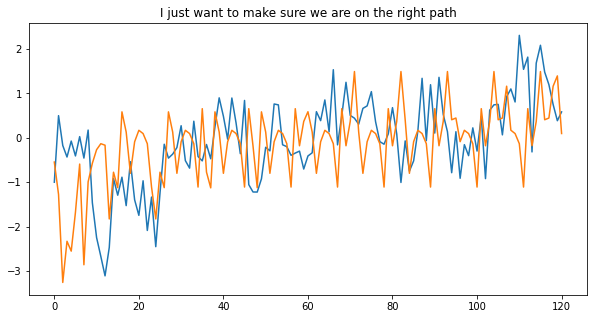

In [54]:
mean = np.mean(np.sum(processed, axis=1))
std = np.std(np.sum(processed, axis=1))
normalized = (np.sum(processed, axis=1) - mean) / std
normalized =normalized[:len(input_data)]

plt.figure(figsize=(10,5))
plt.plot(input_data)
plt.plot(normalized.tolist())
plt.title('I just want to make sure we are on the right path')

In [34]:
# or more generally
from statsmodels.iolib.smpickle import load_pickle
model = load_pickle(PATH+'/models_rnn/ARIMA_latest.pickle')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                           
===============================================================================
Dep. Variable:                       y   No. Observations:                  121
Model:             SARIMAX(2, 9, 0, 1)   Log Likelihood              -14262.112
Date:                 Wed, 13 May 2020   AIC                          28554.223
Time:                         10:46:44   BIC                          28594.730
Sample:                              0   HQIC                         28570.653
                                 - 121                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -6.3050      0.026   -244.752      0.000      -6.355      -6.255
x2             2.7700      0.013    217.646      0.000       2.745       2.795
x3             1.1164      0.009    122.565      0.000       1.099       1.134
x4            -0.9004      0.016    -57.255      0.000      -0.931      -0.870
x5            -2.2821      0.021   -106.997      0.000      -2.324      -2.240
x6             1.6189      0.011    148.031      0.000       1.597       1.640
x7             2.1676      0.016    136.246      0.000       2.136       2.199
x8            -2.3688      0.013   -189.211      0.000      -2.393      -2.344
x9            -3.4762      0.019   -187.531      0.000      -3.513      -3.440
x10            3.8164      0.017    225.866      0.000       3.783       3.850
x11           -3.3441      0.017   -192.545      0.000      -3.378      -3.310
x12            1.4197      0.010    139.999      0.000       1.400       1.440
ar.S.L1        6.7180      0.078     86.370      0.000       6.566       6.870
ar.S.L2       -7.7872      0.076   -103.053      0.000      -7.935      -7.639
sigma2         1.9579      0.044     44.973      0.000       1.873       2.043
===================================================================================
Ljung-Box (Q):                      541.97   Jarque-Bera (JB):                 1.75
Prob(Q):                              0.00   Prob(JB):                         0.42
Heteroskedasticity (H):               0.85   Skew:                             0.09
Prob(H) (two-sided):                  0.63   Kurtosis:                         2.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

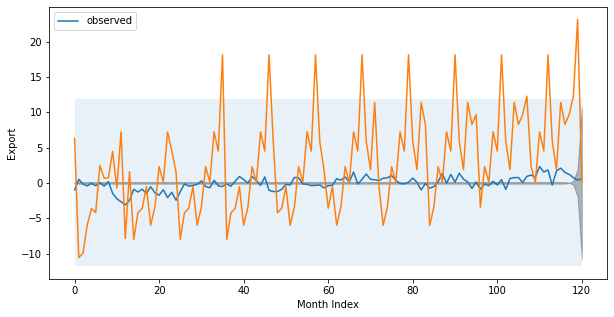

'\n#print(pred_dynamic.predicted_mean)\n\n#plt.plot(input_data)\n'

In [35]:
pred_dynamic =model.get_prediction(start=0, dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()
pred_dynamic_ci_0 =(pred_dynamic_ci.T[0] - np.mean(pred_dynamic_ci.T[0]))/np.std(pred_dynamic_ci.T[0])
pred_dynamic_ci_1 =(pred_dynamic_ci.T[1] - np.mean(pred_dynamic_ci.T[1]))/np.std(pred_dynamic_ci.T[1])

df = pd.DataFrame({
                   "y": y.tolist()
})
ax = df['y'].plot(label='observed', figsize=(10,5))
#pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between([i for i in range(0,len(input_data))],
                pred_dynamic_ci_0,
                pred_dynamic_ci_1, color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), 0, df.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Month Index')
ax.set_ylabel('Export')
plt.plot(pred_dynamic.predicted_mean)

plt.legend()

plt.show()

"""
#print(pred_dynamic.predicted_mean)

#plt.plot(input_data)
"""

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


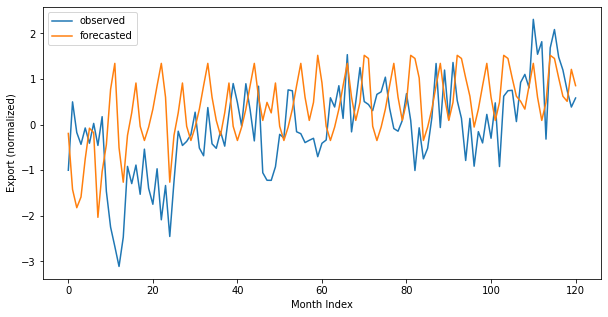

In [63]:
mod = sm.tsa.statespace.SARIMAX(endog = y,
                                exog =x , 
                                order=(0, 0, 0),
                                seasonal_order=(0, 9, 6, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
SARIMAX_2823 = mod.fit()


pred_dynamic =SARIMAX_2823.get_prediction(start=0, dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()
pred_dynamic_ci_0 =(pred_dynamic_ci.T[0] - np.mean(pred_dynamic_ci.T[0]))/np.std(pred_dynamic_ci.T[0])
pred_dynamic_ci_1 =(pred_dynamic_ci.T[1] - np.mean(pred_dynamic_ci.T[1]))/np.std(pred_dynamic_ci.T[1])

df = pd.DataFrame({
                   "y": y.tolist(),
                   "predicted":pred_dynamic.predicted_mean
})
ax = df['y'].plot(label='observed', figsize=(10,5))
ax = df['predicted'].plot(label='forecasted', figsize=(10,5))
#pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

#ax.fill_between([i for i in range(0,len(input_data))],
#                pred_dynamic_ci_0,
#                pred_dynamic_ci_1, color='k', alpha=.25)
#ax.fill_betweenx(ax.get_ylim(), 0, df.index[-1],
#                 alpha=.1, zorder=-1)

ax.set_xlabel('Month Index')
ax.set_ylabel('Export (normalized)')

plt.legend()

plt.show()

No handles with labels found to put in legend.


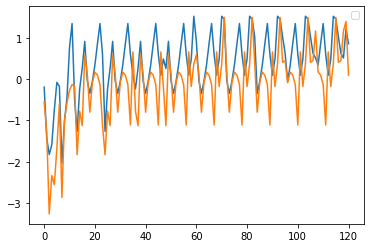

In [49]:
df = pd.DataFrame({
                   "y": y.tolist()
})
ax.set_xlabel('Month Index')
ax.set_ylabel('Export')
plt.plot(pred_dynamic.predicted_mean)
plt.legend()
plt.plot(normalized.tolist())
plt.show()

In [53]:
mod = sm.GLS(y, x)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 GLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.175
Model:                            GLS   Adj. R-squared (uncentered):              0.084
Method:                 Least Squares   F-statistic:                              1.924
Date:                Wed, 13 May 2020   Prob (F-statistic):                      0.0389
Time:                        11:13:07   Log-Likelihood:                         -157.51
No. Observations:                 121   AIC:                                      339.0
Df Residuals:                     109   BIC:                                      372.6
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0525      0.184     -0.286      0.776      -0.417       0.312
x2             0.2372      0.126      1.885      0.062      -0.012       0.487
x3             0.2469      0.160      1.541      0.126      -0.071       0.564
x4             0.0054      0.347      0.016      0.988      -0.682       0.693
x5            -0.1135      0.259     -0.439      0.662      -0.626       0.399
x6             0.2622      0.268      0.977      0.331      -0.270       0.794
x7             0.0898      0.273      0.329      0.743      -0.451       0.630
x8            -0.1237      0.210     -0.588      0.558      -0.541       0.293
x9             0.0960      0.265      0.362      0.718      -0.430       0.622
x10            0.0306      0.180      0.170      0.865      -0.327       0.388
x11            0.1787      0.157      1.140      0.257      -0.132       0.489
x12           -0.0031      0.167     -0.019      0.985      -0.333       0.327
==============================================================================
Omnibus:                        5.961   Durbin-Watson:                   0.891
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                5.468
Skew:                          -0.444   Prob(JB):                       0.0650
Kurtosis:                       3.543   Cond. No.                         14.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""